In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import statsmodels.api as sm # type: ignore
import statsmodels.formula.api as smf # type: ignore
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif # type: ignore
from stargazer.stargazer import Stargazer # type: ignore

from IPython.display import display, HTML # type: ignore
pd.set_option('display.max_columns', None)


In [2]:
# Bring in the data
df = pd.read_csv('../data/HuntersGreenHomeSales_prepped.csv')

# Have a peak
df.head()


,slnoskm,Status,Address,Street_only,lat,long,Beds,bathsfull,bathshalf,bathstotal,sqft,garages,roof_Built-Up,roof_Concrete,roof_Shake,roof_Shingle,roof_Slate,roof_Tile,roof_Other,lotsqft,yrblt,pool_Community,pool_Private,pool_None,spa,subdivn,adom_agentdaysonmarket,cdom_cumuldaysmls,listprice,lppersqft,PendingDate,pd_dom,pd_moy,pd_year,sppersqft,datesold,ds_dom,ds_moy,ds_year,splsale,splsal_Auction,splsal_shortsale,splsale_BankOwnedREO,pricesold,days_on_market
0,1,Sold,17711 ESPRIT DR,ESPRIT DR,28.127921,-82.340184,3,2,0,2,1695,2.0,0,0,0,1,0,0,0,8694,1992,1,0,0,NaN,HUNTERS GREEN PH 1B 02,2,2,150000,88.50,7/12/2017,12,7,2017,83.48,10/6/2018,6,10,2018,Short Sale,0,1,0,141500,451
1,2,Sold,17769 ESPRIT DR,ESPRIT DR,28.130015,-82.339863,2,2,0,2,1305,2.0,0,0,0,1,0,0,0,6540,1992,0,0,1,NaN,HUNTERS GREEN PH 1A,133,133,179000,137.16,7/2/2015,2,7,2015,122.61,7/30/2015,30,7,2015,NaN,0,0,0,160000,28
2,3,Sold,17622 ESPRIT DR,ESPRIT DR,28.129953,-82.341055,3,2,0,2,1420,2.0,0,0,0,1,0,0,0,4845,1991,1,0,0,NaN,HUNTERS GREEN PRCL 17B PH 1A,4,4,165000,116.20,6/17/2015,17,6,2015,113.73,7/29/2015,29,7,2015,NaN,0,0,0,161500,42
3,4,Sold,18111 ASHTON PARK WAY,ASHTON PARK WAY,28.138067,-82.333513,3,2,0,2,1598,2.0,0,0,0,1,0,0,0,5750,1996,1,0,0,NaN,HUNTERS GREEN,44,44,184000,115.14,6/24/2016,24,6,2016,106.38,7/29/2016,29,7,2016,NaN,0,0,0,170000,35
4,5,Sold,9203 CELEBRATION CT,CELEBRATION CT,28.129131,-82.340659,4,2,1,3,2302,2.0,0,0,0,1,0,0,0,5390,1992,0,1,0,NaN,HUNTERS GREEN PH 1B 02,14,14,180000,78.19,8/10/2015,10,8,2015,73.85,9/30/2016,30,9,2016,Short Sale,0,1,0,170000,417


In [3]:
# show me null data
df.isnull().sum()

slnoskm                     0
Status                      0
Address                     0
Street_only                 0
lat                         0
long                        0
Beds                        0
bathsfull                   0
bathshalf                   0
bathstotal                  0
sqft                        0
garages                     4
roof_Built-Up               0
roof_Concrete               0
roof_Shake                  0
roof_Shingle                0
roof_Slate                  0
roof_Tile                   0
roof_Other                  0
lotsqft                     0
yrblt                       0
pool_Community              0
pool_Private                0
pool_None                   0
spa                       313
subdivn                     0
adom_agentdaysonmarket      0
cdom_cumuldaysmls           0
listprice                   0
lppersqft                   0
PendingDate                 0
pd_dom                      0
pd_moy                      0
pd_year   

Let's drop the spa and splsale columns before we drop null rows so we don't lose a ton of data.  splsale has been recaptured by breakout columns.

In [4]:
df = df.drop(['spa', 'splsale'], axis=1)
df = df.dropna()

In [5]:
df.describe()


,slnoskm,lat,long,Beds,bathsfull,bathshalf,bathstotal,sqft,garages,roof_Built-Up,roof_Concrete,roof_Shake,roof_Shingle,roof_Slate,roof_Tile,roof_Other,lotsqft,yrblt,pool_Community,pool_Private,pool_None,adom_agentdaysonmarket,cdom_cumuldaysmls,listprice,lppersqft,pd_dom,pd_moy,pd_year,sppersqft,ds_dom,ds_moy,ds_year,splsal_Auction,splsal_shortsale,splsale_BankOwnedREO,pricesold,days_on_market
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000
mean,241.834728,28.131651,-82.342580,3.864017,2.656904,0.341004,2.997908,2639.857741,2.493724,0.002092,0.002092,0.002092,0.495816,0.004184,0.500000,0.002092,10937.211297,1994.127615,0.294979,0.707113,0.169456,61.456067,71.809623,3.567902e+05,132.708577,15.579498,6.135983,2016.930962,129.312594,17.543933,6.675732,2016.995816,0.006276,0.016736,0.041841,3.466532e+05,42.104603
std,139.491364,0.004647,0.008928,0.703631,0.687919,0.496141,0.830496,827.257195,0.552261,0.045739,0.045739,0.045739,0.500506,0.064617,0.500524,0.045739,6347.880281,2.580858,0.456511,0.455564,0.375547,80.380705,94.172215,1.641413e+05,21.930358,8.738992,3.117598,1.375681,21.024089,9.243342,3.106340,1.364411,0.079056,0.128416,0.200435,1.523696e+05,32.869055
min,1.000000,28.120558,-82.361649,2.000000,2.000000,0.000000,2.000000,1305.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1989.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05,74.920000,1.000000,1.000000,2015.000000,73.850000,1.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,1.415000e+05,0.000000
25%,121.250000,28.128696,-82.349495,3.000000,2.000000,0.000000,3.000000,2079.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7150.000000,1992.000000,0.000000,0.000000,0.000000,10.000000,11.000000,2.500000e+05,118.765000,8.000000,4.000000,2016.000000,114.962500,10.000000,4.000000,2016.000000,0.000000,0.000000,0.000000,2.479250e+05,30.000000
50%,242.500000,28.130965,-82.340279,4.000000,3.000000,0.000000,3.000000,2529.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,9677.500000,1994.000000,0.000000,1.000000,0.000000,34.000000,39.000000,3.300000e+05,132.790000,15.000000,6.000000,2017.000000,129.595000,17.500000,7.000000,2017.000000,0.000000,0.000000,0.000000,3.277500e+05,38.000000
75%,361.750000,28.134790,-82.335950,4.000000,3.000000,1.000000,3.000000,3009.500000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,12431.500000,1996.000000,1.000000,1.000000,0.000000,78.000000,93.000000,4.000000e+05,144.700000,23.000000,8.000000,2018.000000,142.227500,26.000000,9.000000,2018.000000,0.000000,0.000000,0.000000,3.965000e+05,48.000000
max,482.000000,28.141323,-82.327339,6.000000,6.000000,2.000000,8.000000,8398.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52438.000000,2006.000000,1.000000,1.000000,1.000000,633.000000,674.000000,1.695000e+06,248.290000,31.000000,12.000000,2019.000000,218.160000,31.000000,12.000000,2020.000000,1.000000,1.000000,1.000000,1.435000e+06,451.000000


In [17]:
# let's transform
df['log_sqft'] = np.log1p(df['sqft'])
df['house_age'] = df['pd_year'] - df['yrblt']
df.describe()
# df.head()

,slnoskm,lat,long,Beds,bathsfull,bathshalf,bathstotal,sqft,garages,roof_Built-Up,roof_Concrete,roof_Shake,roof_Shingle,roof_Slate,roof_Tile,roof_Other,lotsqft,yrblt,pool_Community,pool_Private,pool_None,adom_agentdaysonmarket,cdom_cumuldaysmls,listprice,lppersqft,pd_dom,pd_moy,pd_year,sppersqft,ds_dom,ds_moy,ds_year,splsal_Auction,splsal_shortsale,splsale_BankOwnedREO,pricesold,days_on_market,log_sqft,house_age
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,4.780000e+02,478.000000,478.000000,478.000000
mean,241.834728,28.131651,-82.342580,3.864017,2.656904,0.341004,2.997908,2639.857741,2.493724,0.002092,0.002092,0.002092,0.495816,0.004184,0.500000,0.002092,10937.211297,1994.127615,0.294979,0.707113,0.169456,61.456067,71.809623,3.567902e+05,132.708577,15.579498,6.135983,2016.930962,129.312594,17.543933,6.675732,2016.995816,0.006276,0.016736,0.041841,3.466532e+05,42.104603,7.837274,22.803347
std,139.491364,0.004647,0.008928,0.703631,0.687919,0.496141,0.830496,827.257195,0.552261,0.045739,0.045739,0.045739,0.500506,0.064617,0.500524,0.045739,6347.880281,2.580858,0.456511,0.455564,0.375547,80.380705,94.172215,1.641413e+05,21.930358,8.738992,3.117598,1.375681,21.024089,9.243342,3.106340,1.364411,0.079056,0.128416,0.200435,1.523696e+05,32.869055,0.281985,2.990381
min,1.000000,28.120558,-82.361649,2.000000,2.000000,0.000000,2.000000,1305.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1989.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+05,74.920000,1.000000,1.000000,2015.000000,73.850000,1.000000,1.000000,2015.000000,0.000000,0.000000,0.000000,1.415000e+05,0.000000,7.174724,12.000000
25%,121.250000,28.128696,-82.349495,3.000000,2.000000,0.000000,3.000000,2079.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7150.000000,1992.000000,0.000000,0.000000,0.000000,10.000000,11.000000,2.500000e+05,118.765000,8.000000,4.000000,2016.000000,114.962500,10.000000,4.000000,2016.000000,0.000000,0.000000,0.000000,2.479250e+05,30.000000,7.640123,21.000000
50%,242.500000,28.130965,-82.340279,4.000000,3.000000,0.000000,3.000000,2529.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,9677.500000,1994.000000,0.000000,1.000000,0.000000,34.000000,39.000000,3.300000e+05,132.790000,15.000000,6.000000,2017.000000,129.595000,17.500000,7.000000,2017.000000,0.000000,0.000000,0.000000,3.277500e+05,38.000000,7.835974,23.000000
75%,361.750000,28.134790,-82.335950,4.000000,3.000000,1.000000,3.000000,3009.500000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,12431.500000,1996.000000,1.000000,1.000000,0.000000,78.000000,93.000000,4.000000e+05,144.700000,23.000000,8.000000,2018.000000,142.227500,26.000000,9.000000,2018.000000,0.000000,0.000000,0.000000,3.965000e+05,48.000000,8.009861,25.000000
max,482.000000,28.141323,-82.327339,6.000000,6.000000,2.000000,8.000000,8398.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,52438.000000,2006.000000,1.000000,1.000000,1.000000,633.000000,674.000000,1.695000e+06,248.290000,31.000000,12.000000,2019.000000,218.160000,31.000000,12.000000,2020.000000,1.000000,1.000000,1.000000,1.435000e+06,451.000000,9.035868,30.000000


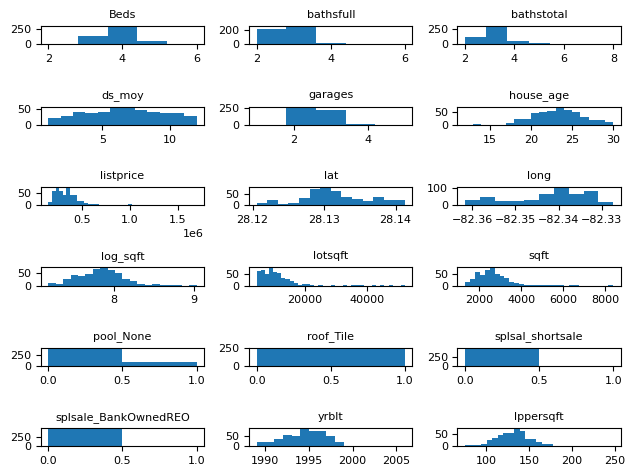

In [22]:
# histograms
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.labelsize': 'small'})
fig, ((Beds, bathsfull, bathstotal), (ds_moy, garages, house_age),
      (listprice, lat, long), (log_sqft, lotsqft, sqft),
      (pool_None, roof_Tile, splsal_shortsale), (splsale_BankOwnedREO, yrblt, lppersqft)) = plt.subplots(nrows=6, ncols=3)

Beds.hist(df['Beds'], 5)
Beds.set_title('Beds', fontsize=8)
bathsfull.hist(df['bathsfull'], 5)
bathsfull.set_title('bathsfull', fontsize=8)
bathstotal.hist(df['bathstotal'], 7)
bathstotal.set_title('bathstotal', fontsize=8)
ds_moy.hist(df['ds_moy'], 12)
ds_moy.set_title('ds_moy', fontsize=8)
garages.hist(df['garages'],5)
garages.set_title('garages', fontsize=8)
house_age.hist(df['house_age'], 'auto')
house_age.set_title('house_age', fontsize=8)
listprice.hist(df['listprice'], 'auto')
listprice.set_title('listprice', fontsize=8)
lat.hist(df['lat'], 'auto')
lat.set_title('lat', fontsize=8)
long.hist(df['long'], 'auto')
long.set_title('long', fontsize=8)
log_sqft.hist(df['log_sqft'], 'auto')
log_sqft.set_title('log_sqft', fontsize=8)
lotsqft.hist(df['lotsqft'], 'auto')
lotsqft.set_title('lotsqft', fontsize=8)
sqft.hist(df['sqft'], 'auto')
sqft.set_title('sqft', fontsize=8)
pool_None.hist(df['pool_None'], 2)
pool_None.set_title('pool_None', fontsize=8)
roof_Tile.hist(df['roof_Tile'], 2)
roof_Tile.set_title('roof_Tile', fontsize=8)
splsal_shortsale.hist(df['splsal_shortsale'], 2)
splsal_shortsale.set_title('splsal_shortsale', fontsize=8)
splsale_BankOwnedREO.hist(df['splsale_BankOwnedREO'], 2)
splsale_BankOwnedREO.set_title('splsale_BankOwnedREO', fontsize=8)
yrblt.hist(df['yrblt'], 'auto')
yrblt.set_title('yrblt', fontsize=8)
lppersqft.hist(df['lppersqft'], 'auto')
lppersqft.set_title('lppersqft', fontsize=8)

fig.tight_layout()
plt.show()

In [9]:
model1 = smf.ols(formula='pricesold ~ Beds + bathstotal + log_sqft + splsale_BankOwnedREO', data=df).fit()

display(model1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesold   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     368.8
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          7.15e-144
Time:                        23:49:09   Log-Likelihood:                -6043.9
No. Observations:                 478   AIC:                         1.210e+04
Df Residuals:                     473   BIC:                         1.212e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.465e+06   1.59e+05    -15.472      0.000   -2.78e+06   -2.15e+06
Beds                 -1.872e+04   7124.129     -2.628      0.009   -3.27e+04   -4723.479
bathstotal            5.922e+04   7315.961      8.095      0.000    4.48e+04    7.36e+04
log_sqft              3.457e+05   2.35e+04     14.692      0.000    2.99e+05    3.92e+05
splsale_BankOwnedREO -6.232e+04   1.73e+04     -3.611      0.000   -9.62e+04   -2.84e+04
==============================================================================
Omnibus:                      198.646   Durbin-Watson:                   1.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1633.387
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                      11.483   Cond. No.                         435.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
model2 = smf.ols(formula='pricesold ~ lat + long + yrblt + garages + pool_None + ds_moy', data=df).fit()

display(model2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesold   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     90.49
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           3.09e-75
Time:                        23:49:09   Log-Likelihood:                -6199.0
No. Observations:                 478   AIC:                         1.241e+04
Df Residuals:                     471   BIC:                         1.244e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -8.54e+08    8.8e+07     -9.700      0.000   -1.03e+09   -6.81e+08
lat         9.323e+06   1.43e+06      6.520      0.000    6.51e+06    1.21e+07
long       -6.905e+06    7.3e+05     -9.462      0.000   -8.34e+06   -5.47e+06
yrblt       1.163e+04   2343.949      4.961      0.000    7021.293    1.62e+04
garages     1.134e+05   1.03e+04     11.002      0.000    9.31e+04    1.34e+05
pool_None  -4.681e+04   1.35e+04     -3.472      0.001   -7.33e+04   -2.03e+04
ds_moy     -1956.6291   1545.612     -1.266      0.206   -4993.778    1080.520
==============================================================================
Omnibus:                      245.086   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2081.315
Skew:                           2.059   Prob(JB):                         0.00
Kurtosis:                      12.357   Cond. No.                     3.68e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
model3 = smf.ols(formula='pricesold ~ long + splsal_shortsale + pool_None + roof_Tile + house_age', data=df).fit()

display(model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesold   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     54.42
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           1.37e-44
Time:                        23:49:09   Log-Likelihood:                -6273.4
No. Observations:                 478   AIC:                         1.256e+04
Df Residuals:                     472   BIC:                         1.258e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -4.202e+08   5.64e+07     -7.454      0.000   -5.31e+08   -3.09e+08
long              -5.11e+06   6.85e+05     -7.462      0.000   -6.46e+06   -3.76e+06
splsal_shortsale -1.316e+05   4.35e+04     -3.024      0.003   -2.17e+05   -4.61e+04
pool_None        -7.635e+04   1.56e+04     -4.905      0.000   -1.07e+05   -4.58e+04
roof_Tile         1.116e+05   1.17e+04      9.522      0.000    8.86e+04    1.35e+05
house_age        -1.328e+04   2042.898     -6.501      0.000   -1.73e+04   -9266.506
==============================================================================
Omnibus:                      306.293   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3743.916
Skew:                           2.609   Prob(JB):                         0.00
Kurtosis:                      15.679   Cond. No.                     8.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
stargazer = Stargazer([model1, model2, model3])
html = stargazer.render_html()

display(HTML(html))

In [13]:
amodel1 = smf.ols(formula='adom_agentdaysonmarket ~ Beds + sqft + listprice', data=df).fit()

display(amodel1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     adom_agentdaysonmarket   R-squared:                       0.154
Model:                                OLS   Adj. R-squared:                  0.148
Method:                     Least Squares   F-statistic:                     28.69
Date:                    Wed, 26 Feb 2025   Prob (F-statistic):           4.64e-17
Time:                            23:49:09   Log-Likelihood:                -2734.8
No. Observations:                     478   AIC:                             5478.
Df Residuals:                         474   BIC:                             5494.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.7004     19.553     -0.445      0.657     -47.121      29.720
Beds         -13.8415      6.574     -2.105      0.036     -26.759      -0.924
sqft           0.0525      0.011      4.773      0.000       0.031       0.074
listprice  -4.178e-05   5.01e-05     -0.833      0.405      -0.000    5.67e-05
==============================================================================
Omnibus:                      222.292   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1277.897
Skew:                           1.973   Prob(JB):                    3.22e-278
Kurtosis:                       9.971   Cond. No.                     2.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
amodel2 = smf.ols(formula='adom_agentdaysonmarket ~ long + yrblt + lotsqft + bathsfull', data=df).fit()

display(amodel2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     adom_agentdaysonmarket   R-squared:                       0.099
Model:                                OLS   Adj. R-squared:                  0.091
Method:                     Least Squares   F-statistic:                     12.98
Date:                    Wed, 26 Feb 2025   Prob (F-statistic):           4.87e-10
Time:                            23:49:09   Log-Likelihood:                -2749.7
No. Observations:                     478   AIC:                             5509.
Df Residuals:                         473   BIC:                             5530.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.592e+04   4.27e+04      0.373      0.709   -6.79e+04    9.98e+04
long         241.3950    493.477      0.489      0.625    -728.283    1211.073
yrblt          1.9847      1.741      1.140      0.255      -1.436       5.406
lotsqft        0.0027      0.001      3.494      0.001       0.001       0.004
bathsfull     11.3531      7.357      1.543      0.123      -3.103      25.809
==============================================================================
Omnibus:                      236.187   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1469.825
Skew:                           2.092   Prob(JB):                         0.00
Kurtosis:                      10.503   Cond. No.                     1.55e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
amodel3 = smf.ols(formula='adom_agentdaysonmarket ~ house_age + Beds', data=df).fit()

display(amodel3.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     adom_agentdaysonmarket   R-squared:                       0.071
Model:                                OLS   Adj. R-squared:                  0.067
Method:                     Least Squares   F-statistic:                     18.05
Date:                    Wed, 26 Feb 2025   Prob (F-statistic):           2.79e-08
Time:                            23:49:09   Log-Likelihood:                -2757.1
No. Observations:                     478   AIC:                             5520.
Df Residuals:                         475   BIC:                             5533.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    105.5334     37.143      2.841      0.005      32.549     178.518
house_age     -4.9919      1.211     -4.122      0.000      -7.372      -2.612
Beds          18.0524      5.147      3.507      0.000       7.939      28.166
==============================================================================
Omnibus:                      266.085   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1896.099
Skew:                           2.374   Prob(JB):                         0.00
Kurtosis:                      11.524   Cond. No.                         245.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
astargazer = Stargazer([amodel1, amodel2, amodel3])
ahtml = astargazer.render_html()

display(HTML(ahtml))